In [32]:
pip install moexalgo

In [33]:
from moexalgo import Ticker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

In [34]:
imoex = Ticker('IMOEX') #Capitalisation of top 50 russian companies
moexeu = Ticker('MOEXEU') #Electroenergy
mscxm = Ticker('MCXSM') #Medium and small level of capitalisation (companies)

#historical data
hist_data_imoex = imoex.candles(start='2015-01-01', end='2024-12-31', period='1d')
hist_data_moexeu = moexeu.candles(start='2015-01-01', end='2024-12-31', period='1d')
hist_data_mscxm = mscxm.candles(start='2015-01-01', end='2024-12-31', period='1d')

df_imoex = pd.DataFrame(hist_data_imoex)
df_moexeu = pd.DataFrame(hist_data_moexeu)
df_mscxm = pd.DataFrame(hist_data_mscxm)

print(df_imoex.head())
print(df_moexeu.head())
print(df_mscxm.head())

      open    close     high      low         value  volume      begin  \
0  1394.66  1435.66  1438.91  1390.53  1.532069e+10     0.0 2015-01-05   
1  1435.39  1480.73  1481.35  1430.47  2.126881e+10     0.0 2015-01-06   
2  1482.12  1547.39  1564.87  1481.93  3.550506e+10     0.0 2015-01-08   
3  1547.61  1515.37  1557.96  1496.17  2.722306e+10     0.0 2015-01-09   
4  1515.23  1513.22  1534.74  1503.49  2.341906e+10     0.0 2015-01-12   

                  end  
0 2015-01-05 23:59:59  
1 2015-01-06 23:59:59  
2 2015-01-08 23:59:59  
3 2015-01-09 23:59:59  
4 2015-01-12 23:59:59  
     open   close    high     low        value  volume      begin  \
0  795.66  806.48  806.61  789.00  265095005.0     0.0 2015-01-05   
1  806.65  812.13  814.71  802.86  289490613.0     0.0 2015-01-06   
2  812.48  828.76  829.53  812.48  433346658.0     0.0 2015-01-08   
3  828.91  819.23  832.28  811.41  362992620.0     0.0 2015-01-09   
4  818.19  810.25  821.27  807.25  401548116.0     0.0 2015-01-12 

**DLWR**

In [51]:
def locally_weighted_regression(x, y, x_new, frac=0.2, degree=1):
    weights = np.exp(-(x - x_new)**2 / (2 * (frac * len(x))**2))
    W = np.diag(weights)
    X = np.vander(x - x_new, degree + 1)
    theta = linalg.pinv(X.T @ W @ X) @ X.T @ W @ y
    return theta[1]

def dynamic_lwr(data, window=10, frac=0.2):
    n = len(data)
    trend = np.zeros(n)
    for i in range(n):
        start = max(0, i - window + 1)
        x = np.arange(start, i + 1)
        y = data[start:i + 1]
        trend[i] = locally_weighted_regression(x, y, i, frac)
    return trend

def dlwr_trend_separation(data, separations=3, window=10, frac=0.2):
    trends = []
    residuals = data.copy()
    for _ in range(separations):
        trend = dynamic_lwr(residuals, window, frac)
        trends.append(trend)
        residuals = residuals - trend
    return trends, residuals

In [58]:
window_size = 10
frac_param = 0.2
separations = 3

dates_imoex = df_imoex['begin'].values
target_imoex = df_imoex['close'].values

dates_moexeu = df_moexeu['begin'].values
target_moexeu = df_moexeu['close'].values

dates_mscxm = df_mscxm['begin'].values
target_mscxm = df_mscxm['close'].values

trends_imoex, noise_imoex = dlwr_trend_separation(target_imoex, window=window_size, frac=frac_param, separations=separations)

print(target_imoex[0])
print(trends_imoex[0][0])
#Means
print("Means:")
print(f"Mean f0: {np.mean(trends_imoex[0]):.4f}")
print(f"Mean f1: {np.mean(trends_imoex[1]):.4f}")
print(f"Mean f2: {np.mean(trends_imoex[2]):.4f}")
print(f"Mean noise: {np.mean(noise_imoex):.4f}")

#Recunstruction to test whether its close
reconstructed = trends_imoex[0] + trends_imoex[1] + trends_imoex[2] + noise_imoex
reconstruction_error = np.max(np.abs(reconstructed - target_imoex))
print(f"\nMax error reconstruction: {reconstruction_error:.2e}")

1435.66
1435.66
Means:
Mean f0: 2559.1123
Mean f1: 0.0080
Mean f2: 0.0041
Mean noise: 0.0005

Max error reconstruction: 9.09e-13


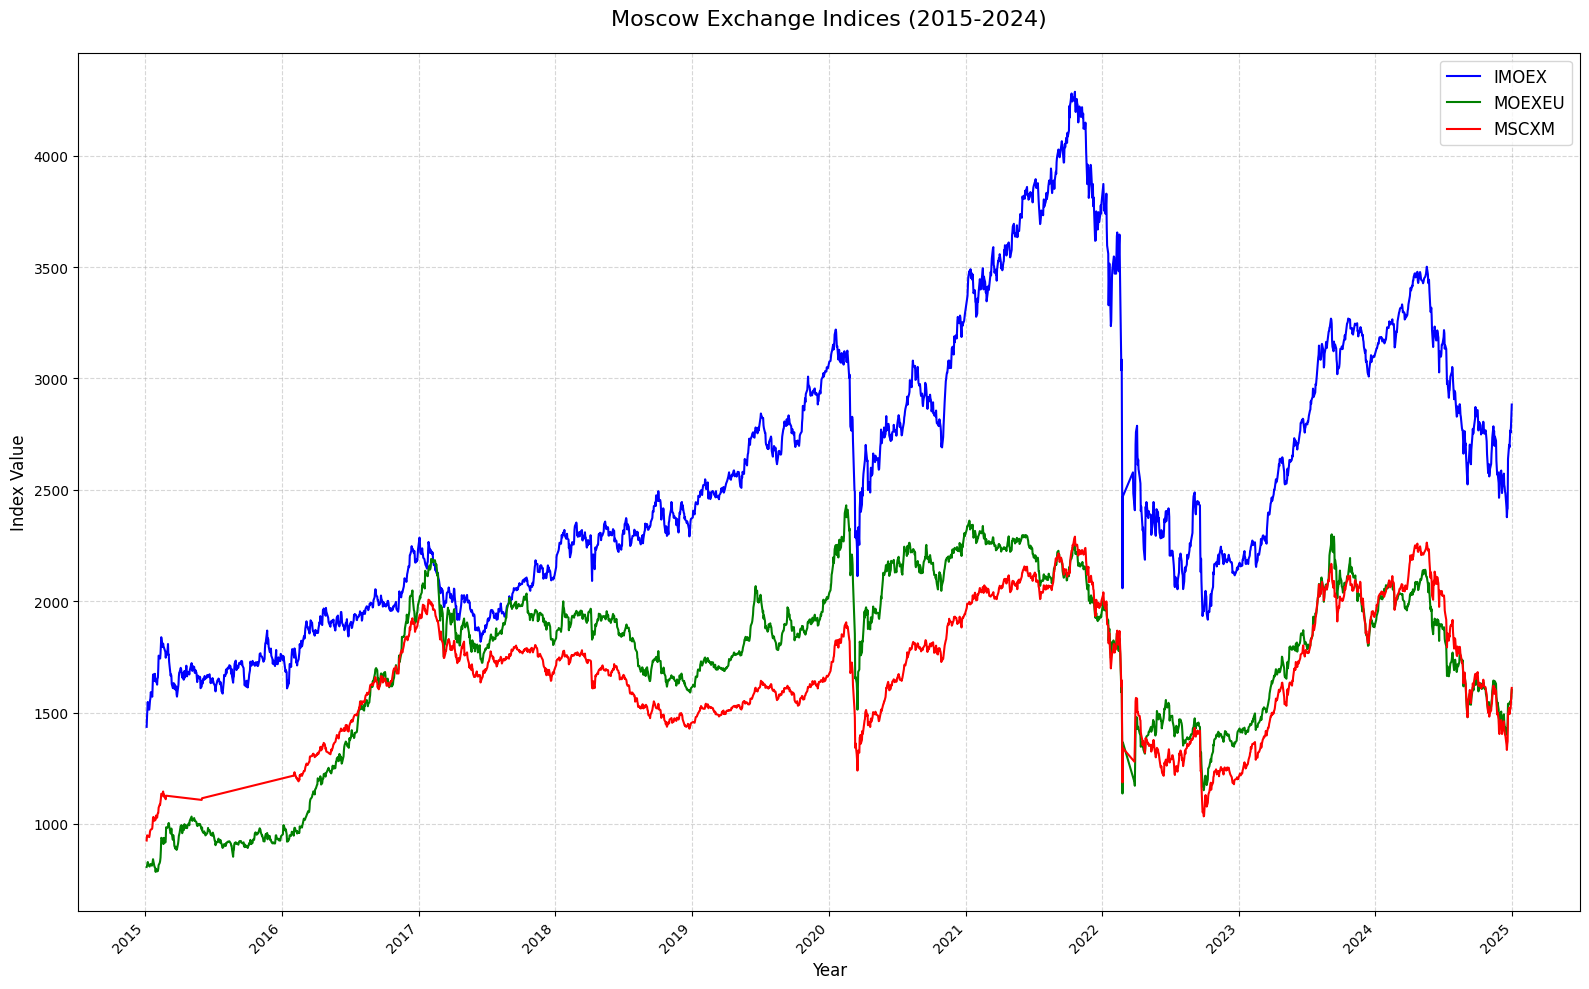

In [59]:
plt.figure(figsize=(16, 10))


plt.plot(dates_imoex, target_imoex, label="IMOEX", color="blue", linewidth=1.5)
plt.plot(dates_moexeu, target_moexeu, label="MOEXEU", color="green", linewidth=1.5)
plt.plot(dates_mscxm, target_mscxm, label="MSCXM", color="red", linewidth=1.5)

plt.title("Moscow Exchange Indices (2015-2024)", fontsize=16, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Index Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)

years = range(2015, 2026)
plt.xticks(
    [pd.Timestamp(f"{year}-01-01") for year in years],
    [str(year) for year in years],
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig("moex_indices_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [60]:
f0_last = trends_imoex[0][-60:]
f1_last = trends_imoex[1][-60:]
f2_last = trends_imoex[2][-60:]
d0_last = (target_imoex - trends_imoex[0])[-60:]
d1_last = (target_imoex - trends_imoex[0] - trends_imoex[1])[-60:]
d2_last = noise_imoex[-60:]
np.mean(trends_imoex)

np.float64(853.0414565899623)

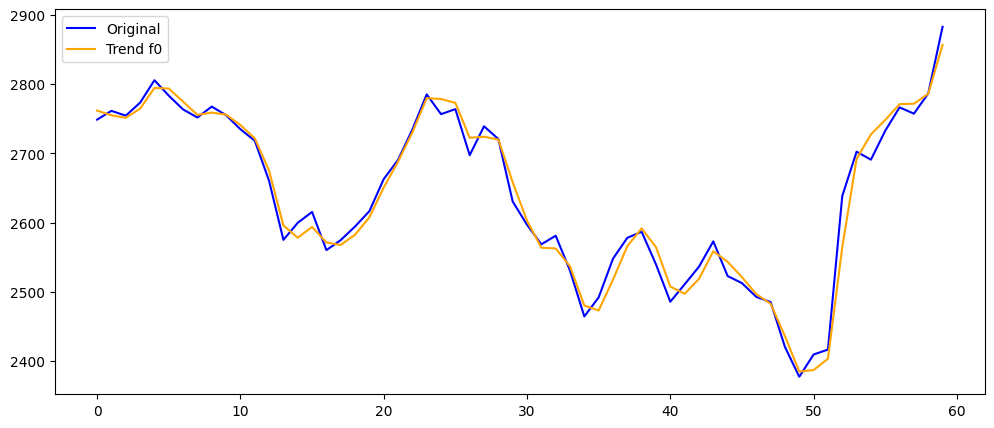

In [73]:
plt.figure(figsize=(12, 5))
plt.plot(target_imoex[-60:], label='Original', color='blue')
plt.plot(f0_last, label='Trend f0', color='orange')
plt.legend()
plt.show()

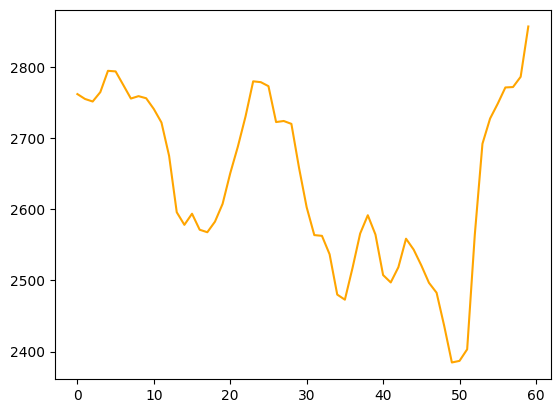

In [62]:
plt.plot(f0_last, color='orange', label='f0')

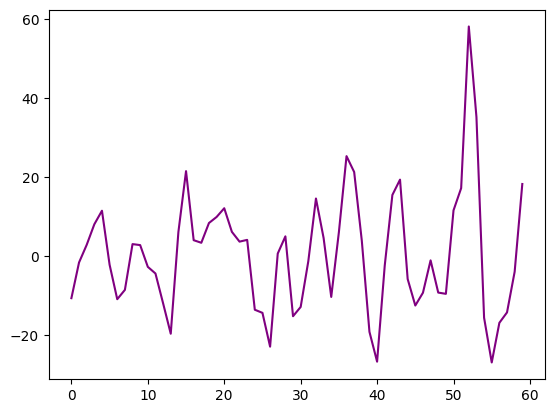

In [63]:
plt.plot(f1_last, color='purple', label='f1')

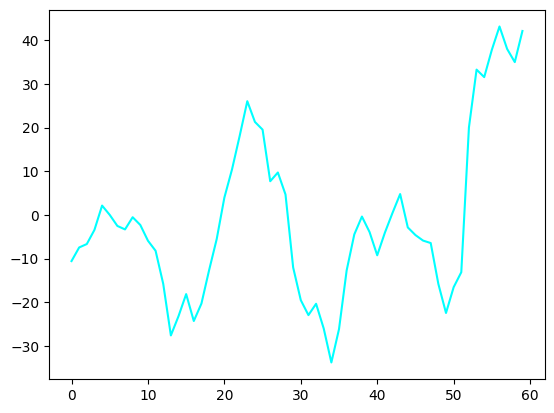

In [ ]:
plt.plot(f2_last, color='cyan', label='f2')

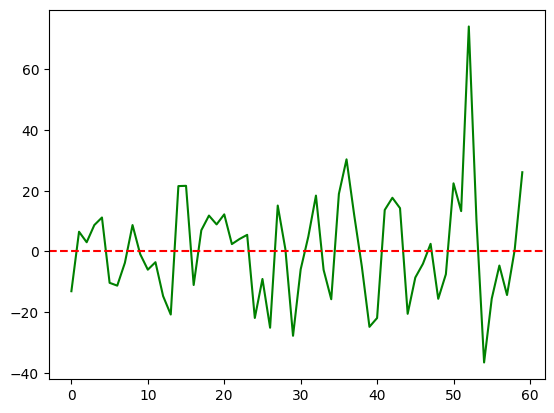

In [64]:
plt.plot(d0_last, color='green', label='d0')
plt.axhline(0, color='red', linestyle='--')

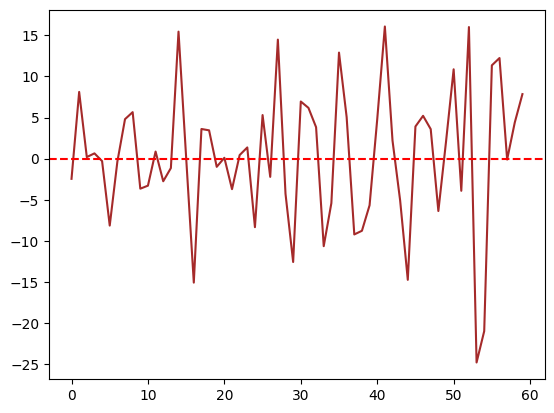

In [65]:
plt.plot(d1_last, color='brown', label='d1')
plt.axhline(0, color='red', linestyle='--')

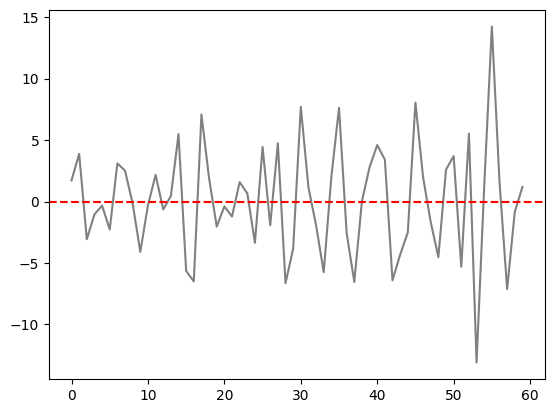

In [66]:
plt.plot(d2_last, color='gray', label='d2')
plt.axhline(0, color='red', linestyle='--')